# Vision Transformer (ViT) Analysis

This notebook provides visualization and qualitative analysis for the ViT experiments.

- `run_inference.py` → attention tensors & predictions
- `run_masking.py` → masking robustness metrics
- `train_linear_probe.py` → CLS vs mean pooling results

In [9]:
import os
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from vit_utils import load_model, extract_cls_attention, extract_attention_rollout

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model, processor = load_model()
model.to(device)

os.makedirs("outputs/attention", exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')

Using device: mps


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

## Part 2: Visualizing Patch Attention

We extract the CLS token's attention to all patch tokens from the final transformer layer.
This shows which parts of the image the model focuses on for classification.

Saved to outputs/attention_comparison/dog_comparison.png


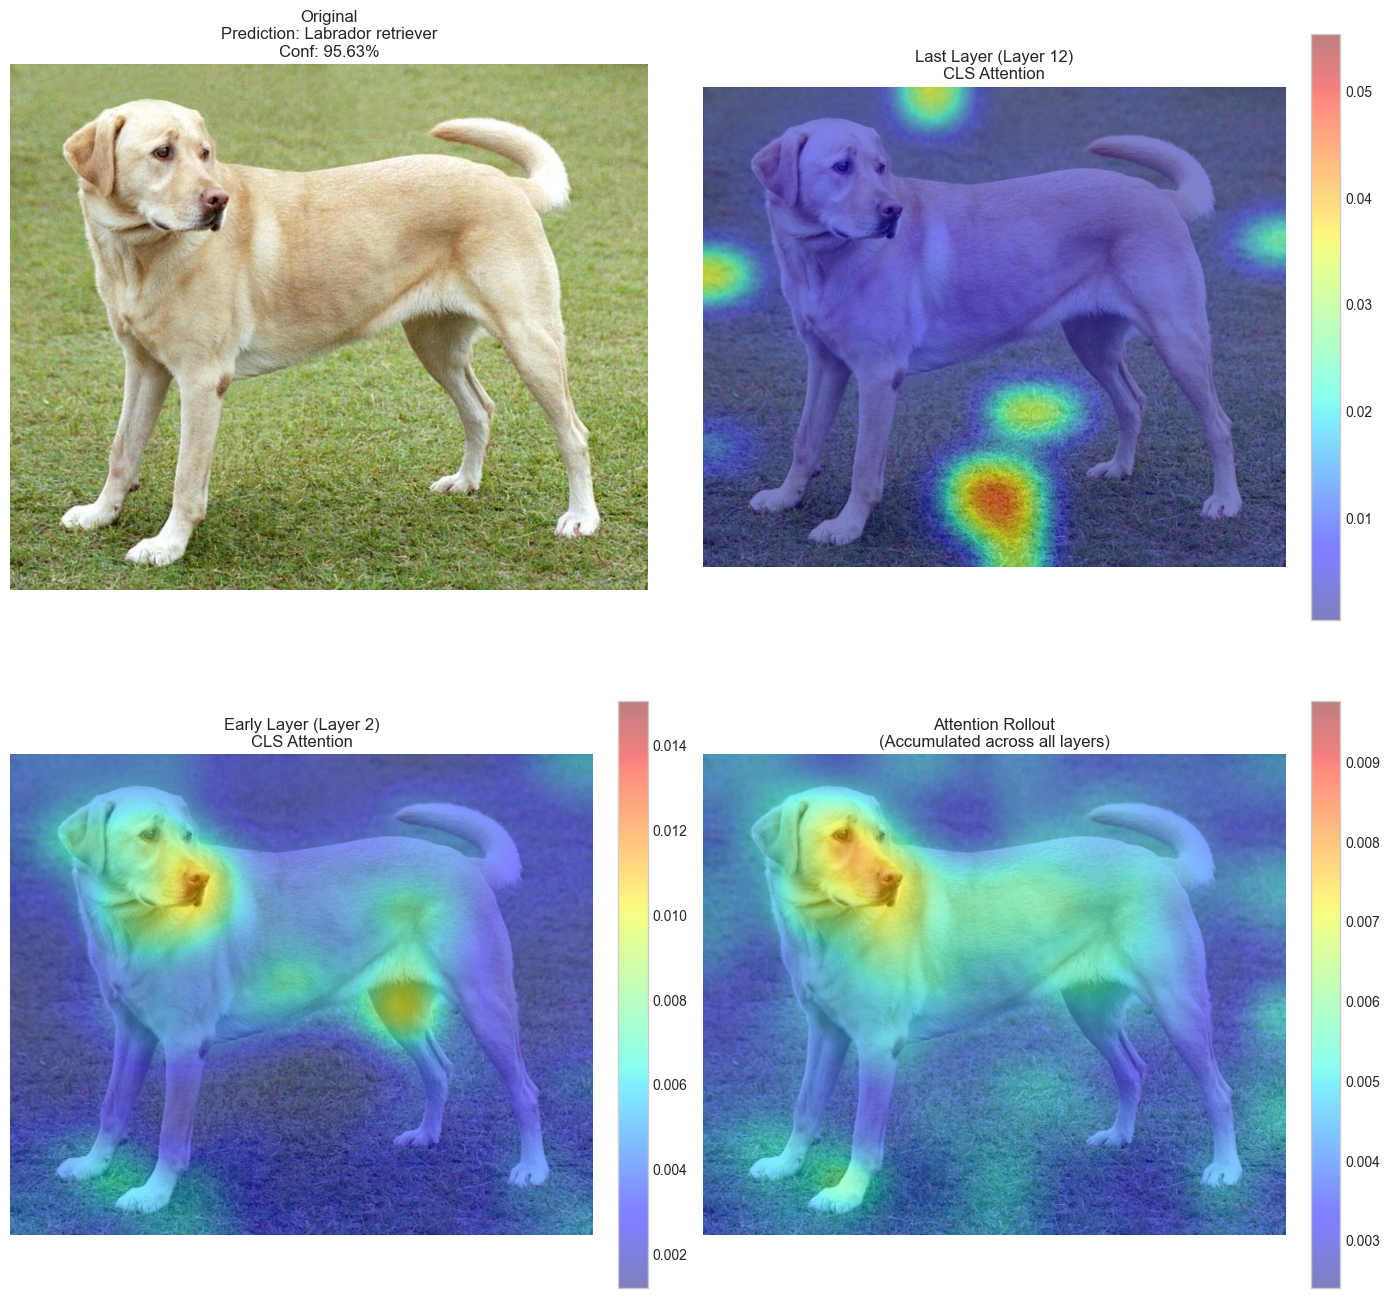

Saved to outputs/attention_comparison/car_comparison.png


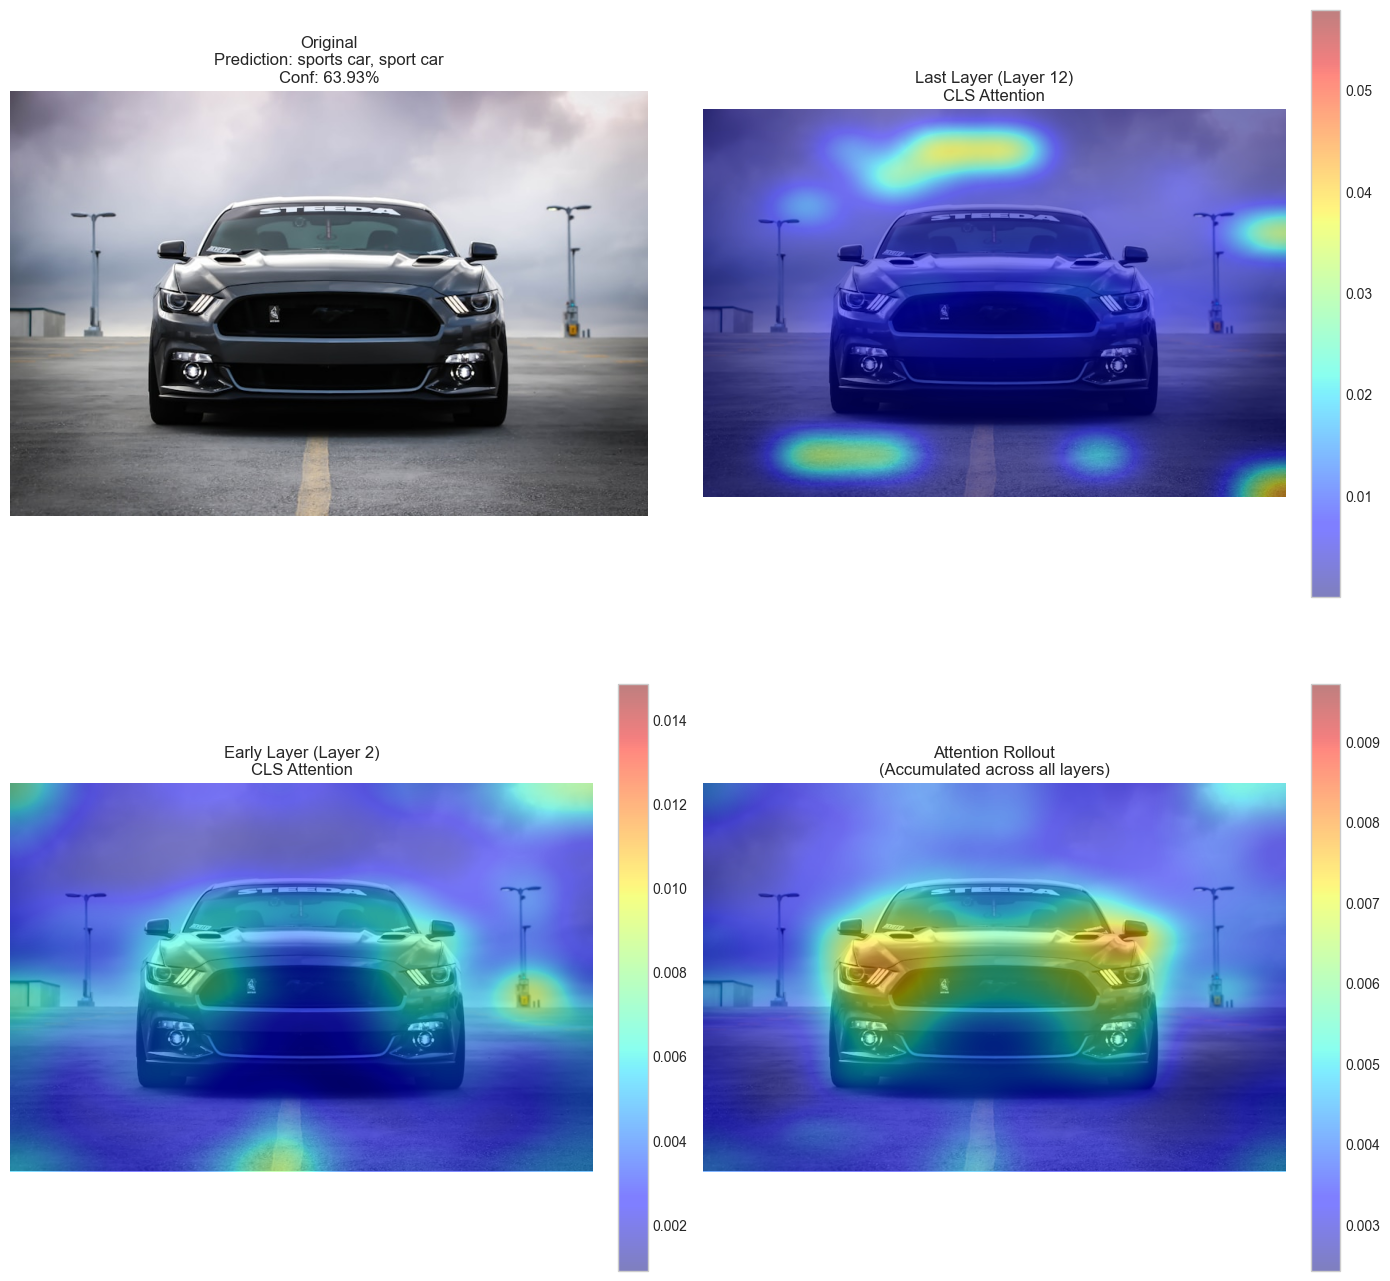

In [ ]:
def visualize_overlay(image_path, model, processor, device):
    # Load Image
    image = Image.open(image_path).convert("RGB")
    original_size = image.size  # (Width, Height)
    
    # Preprocess
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)
    top_prob, top_idx = probs.max(dim=-1)
    predicted_label = model.config.id2label[top_idx.item()]

    # Get Attention & Logits
    # Method 1: Last layer CLS attention
    attn_last, _ = extract_cls_attention(model, inputs, layer_idx=-1)

    # Method 2: Early layer CLS attention (layer 2)
    attn_early, _ = extract_cls_attention(model, inputs, layer_idx=2)

    # Method 3: Attention Rollout
    attn_rollout, _ = extract_attention_rollout(model, inputs)
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    
    # Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f"Original\nPrediction: {predicted_label}\nConf: {top_prob.item():.2%}")
    axes[0, 0].axis('off')
    
    # We display the image first
    axes[0, 1].imshow(image)
    
    # ...then overlay the heatmap.
    # 'extent' automatically stretches the 14x14 grid to fit the original image dimensions.
    # 'bicubic' interpolation makes the blocks look like a smooth heatmap.
    # 'alpha=0.5' gives the required semi-transparency.
    # Method 1: Last layer
    im1 = axes[0, 1].imshow(attn_last, cmap='jet', alpha=0.5, interpolation='bicubic',
                            extent=[0, original_size[0], original_size[1], 0])
    axes[0, 1].set_title("Last Layer (Layer 12)\nCLS Attention")
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Method 2: Early layer
    axes[1, 0].imshow(image)
    im3 = axes[1, 0].imshow(attn_early, cmap='jet', alpha=0.5, interpolation='bicubic',
                            extent=[0, original_size[0], original_size[1], 0])
    axes[1, 0].set_title("Early Layer (Layer 2)\nCLS Attention")
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

    # Method 3: Attention Rollout
    axes[1, 1].imshow(image)
    im4 = axes[1, 1].imshow(attn_rollout, cmap='jet', alpha=0.5, interpolation='bicubic',
                            extent=[0, original_size[0], original_size[1], 0])
    axes[1, 1].set_title("Attention Rollout\n(Accumulated across all layers)")
    axes[1, 1].axis('off')
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

    plt.tight_layout()

    # F. Save and Show
    filename = os.path.basename(image_path).split('.')[0]
    save_path = f"outputs/attention_comparison/{filename}_comparison.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    print(f"Saved to {save_path}")
    plt.show()

# --- Run on all images ---
image_folder = "data/images"
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

for img_file in image_files:
    full_path = os.path.join(image_folder, img_file)
    visualize_overlay(full_path, model, processor, device)

#### Attention Head Comparison

Saved head analysis to outputs/attention_heads/dog_heads.png


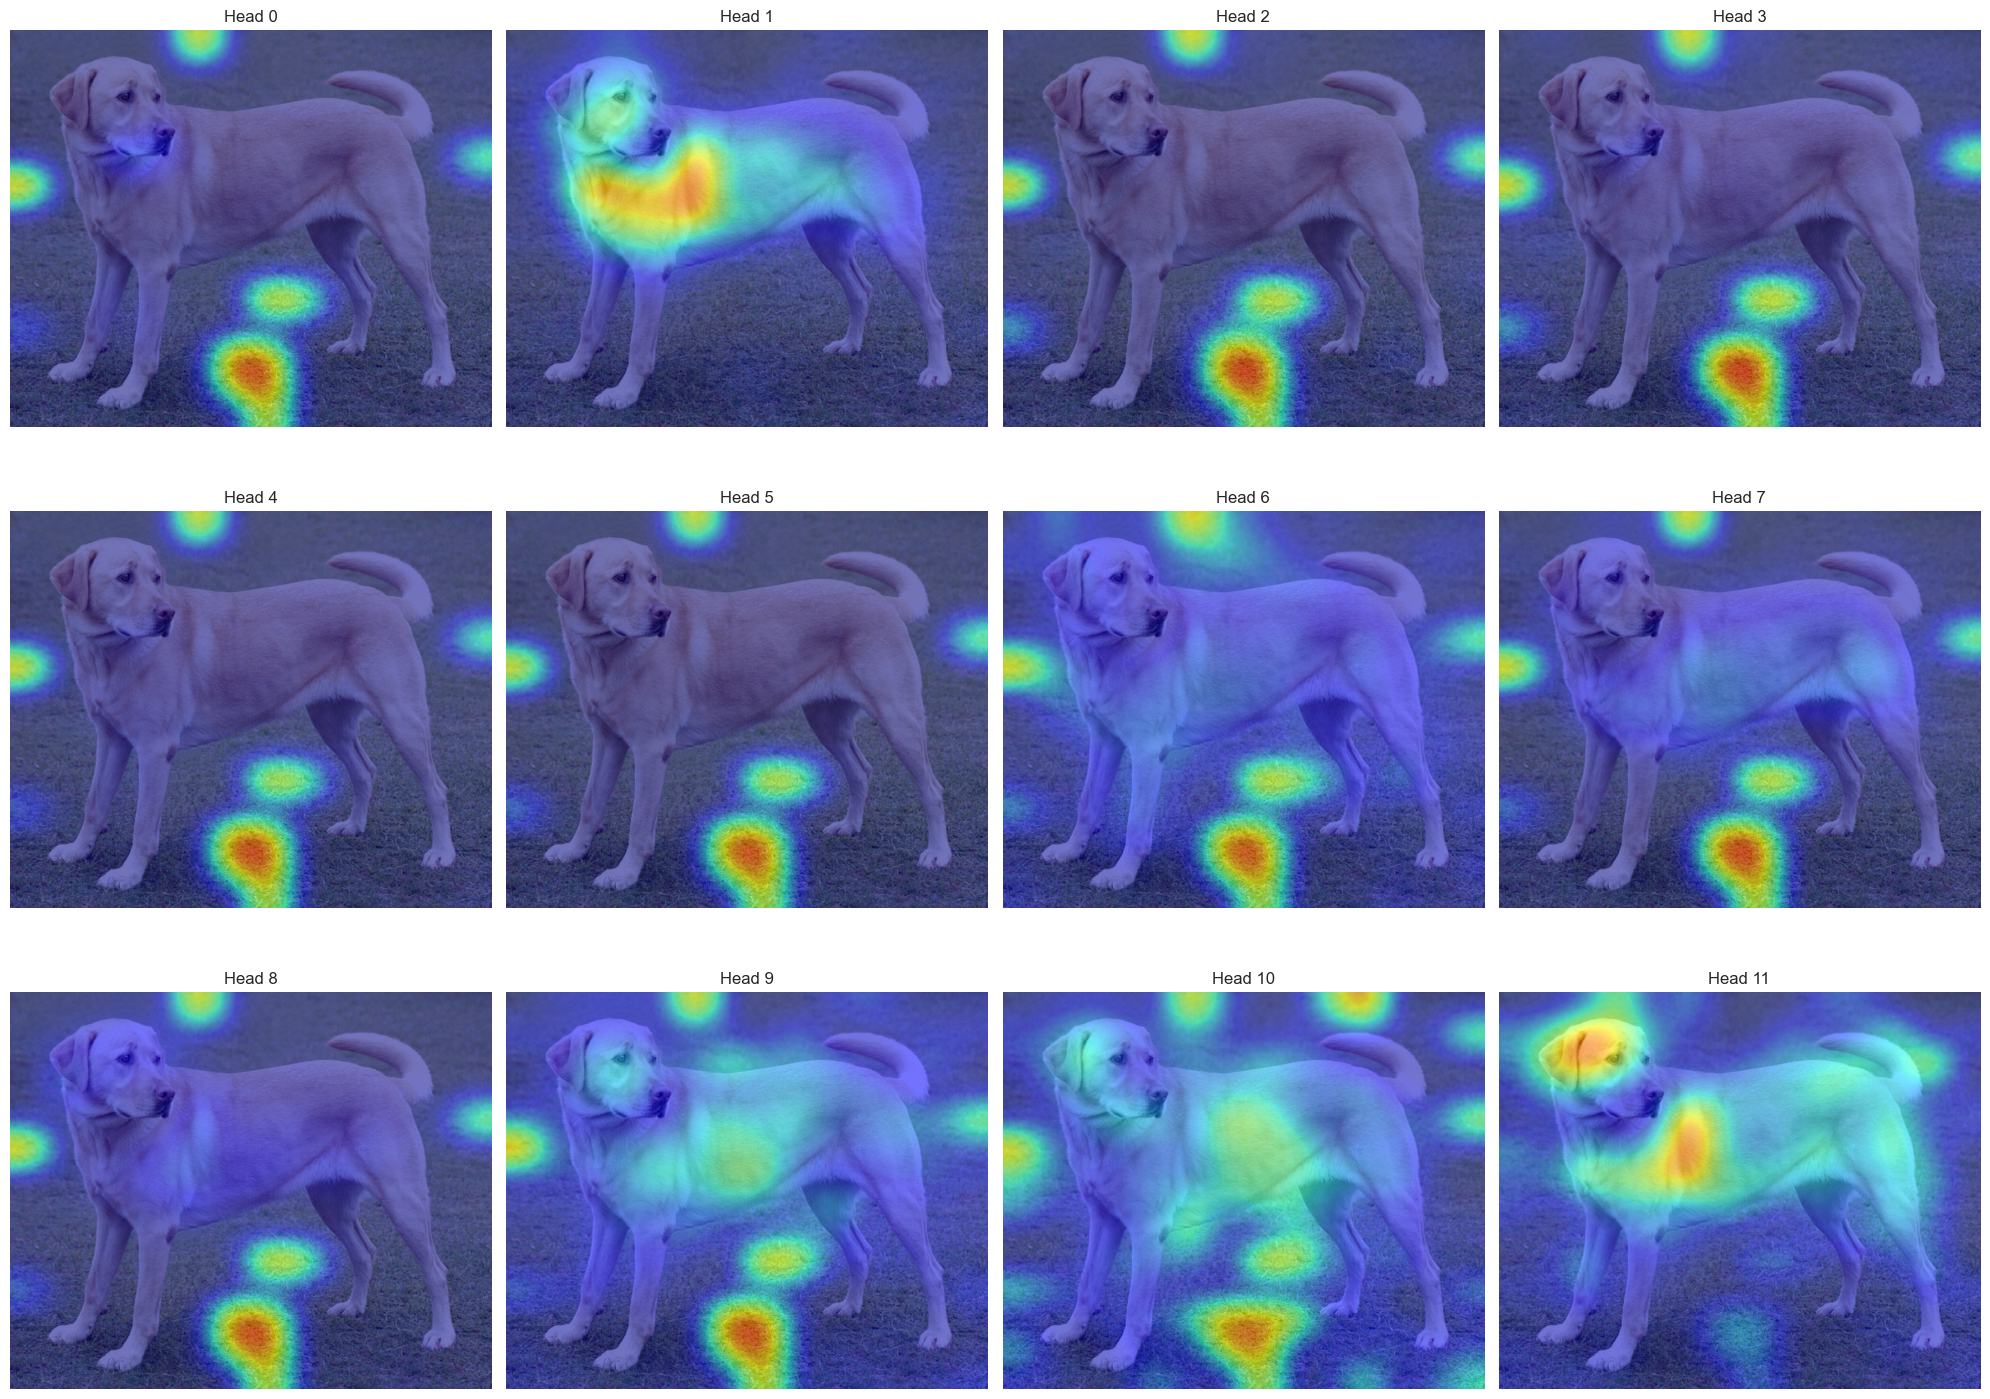

In [11]:
def visualize_heads(image_path, model, processor, device):
    """
    Visualizes the 12 individual attention heads from the last layer to answer:
    'Are different attention heads specialized?'
    """
    # preprocess
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Extract heads without averaging
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get last layer attention: Shape (Batch, Heads, Seq, Seq) -> (1, 12, 197, 197)
    attentions = outputs.attentions[-1]
    
    # Plotting Grid (3 rows x 4 cols = 12 heads)
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    for i in range(12):
        # Extract Head 'i', Row 0 (CLS), Cols 1: (Patches) and manually slice
        head_att = attentions[0, i, 0, 1:].cpu().numpy()
        
        # Reshape to 14x14
        grid_size = int(np.sqrt(head_att.shape[0]))
        head_grid = head_att.reshape(grid_size, grid_size)
        
        # Plot
        axes[i].imshow(image)
        axes[i].imshow(head_grid, cmap='jet', alpha=0.55, interpolation='bicubic',
                       extent=[0, image.size[0], image.size[1], 0])
        axes[i].set_title(f"Head {i}")
        axes[i].axis('off')
        
    plt.tight_layout()
    
    # Save
    filename = os.path.basename(image_path).split('.')[0]
    os.makedirs("outputs/attention_heads", exist_ok=True)
    save_path = f"outputs/attention_heads/{filename}_heads.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    print(f"Saved head analysis to {save_path}")
    plt.show()

# running for only the dog image
if image_files:
    full_path = os.path.join(image_folder, image_files[0])
    visualize_heads(full_path, model, processor, device)

## Part 3: Analyzing the Attention Map

### Observations

1. **Object Localization**: The ViT's attention tends to focus on the main object in the image
   that corresponds to the predicted class. For example, if predicting "dog", the attention
   should highlight the dog's body, face, or distinctive features.

2. **Head Specialization**: Different attention heads appear to focus on different aspects:
   - Some heads focus on local features (edges, textures)
   - Some heads capture global context (background, scene composition)
   - Some heads specifically attend to object boundaries

### Comparison with CNN Methods (CAM/Grad-CAM)

| Aspect | ViT Attention | CNN Grad-CAM |
|--------|--------------|---------------|
| **Computation** | Direct from model, no gradient required | Requires backward pass |
| **Interpretability** | Native to architecture | Post-hoc explanation |
| **Resolution** | Patch-level (14×14 for 16×16 patches) | Depends on feature map size |
| **Multi-head** | Can inspect individual heads | Single heatmap per class |

**Key Advantage of Transformers**: The attention mechanism is inherently interpretable—it
directly tells us how information flows through the network. This is different from CNNs
where interpretability methods like Grad-CAM approximate what the network "looks at."

## Part 4: Robustness to Patch Masking

Load and visualize the masking experiment results.

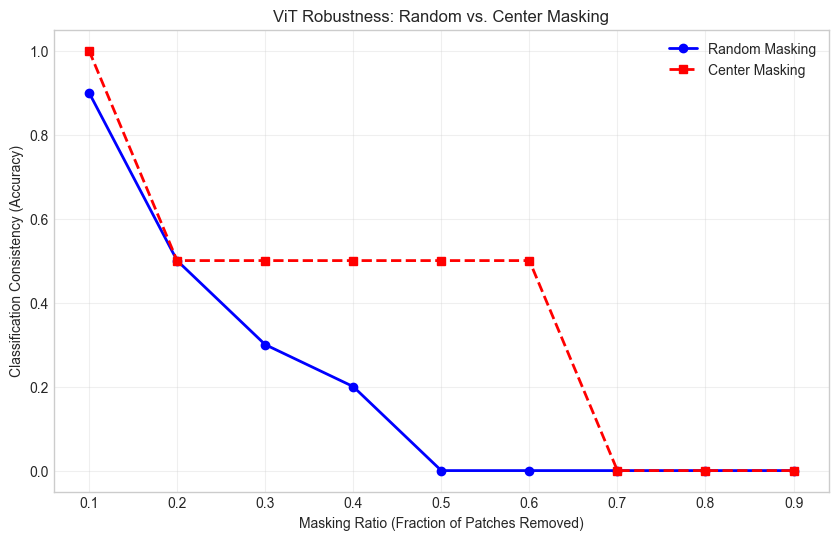

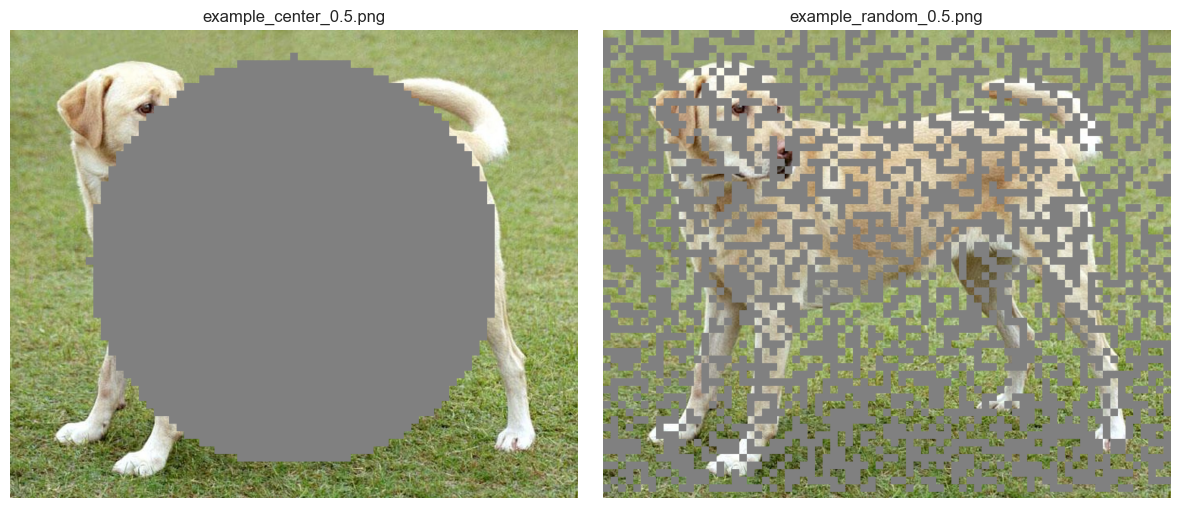

In [12]:
# Load Metrics
json_path = "outputs/masking/metrics.json"

if not os.path.exists(json_path):
    print(f"File not found: {json_path}")
    print("Run 'python run_masking.py' first.")
else:
    with open(json_path, "r") as f:
        data = json.load(f)

    # Extract Data
    results = data['accuracy_results']
    
    # Get ratios from the keys (convert string "0.1" -> float 0.1)
    ratios = sorted([float(k) for k in results['random'].keys()])
    
    # Extract accuracies
    acc_random = [results['random'][str(r)] for r in ratios]
    acc_center = [results['center'][str(r)] for r in ratios]

    # Plotting Performance Drop
    plt.figure(figsize=(10, 6))
    
    # Plot Random Masking Line
    plt.plot(ratios, acc_random, marker='o', label='Random Masking', 
             linewidth=2, color='blue')
    
    # Plot Center Masking Line
    plt.plot(ratios, acc_center, marker='s', label='Center Masking', 
             linewidth=2, linestyle='--', color='red')
    
    plt.title("ViT Robustness: Random vs. Center Masking")
    plt.xlabel("Masking Ratio (Fraction of Patches Removed)")
    plt.ylabel("Classification Consistency (Accuracy)")
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Save Plot
    save_plot = "outputs/masking/robustness_plot.png"
    plt.savefig('outputs/masking/robustness_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Show Qualitative Examples (Generated by run_masking.py)
    example_files = [f for f in os.listdir("outputs/masking") 
                     if f.endswith(".png") and "0.5" in f and "example" in f]
    
    if example_files:
        fig, axes = plt.subplots(1, len(example_files), figsize=(12, 5))
        if len(example_files) == 1: axes = [axes]
        
        for ax, fname in zip(axes, sorted(example_files)):
            img = Image.open(os.path.join("outputs/masking", fname))
            ax.imshow(img)
            ax.set_title(fname)
            ax.axis('off')
        plt.tight_layout()
        plt.savefig('outputs/masking/example_0.5_masking.png', dpi=300, bbox_inches='tight')
        plt.show()